# Extreme variations in Apple's quotation (quantile estimation)

# Data loading and Analysis

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')

In [2]:
# Load and preprocess quotation data of the company Apple - downloaded on NASDAQ website
data = pd.read_csv('Apple.csv')
data = data.drop([0]) 
data['volume'] = pd.to_numeric(data['volume'])
n = data.shape[0]
n # Print Number of data points - each of them correspond to one day

2267

In [3]:
# Head of the dataframe
data.head()

,date,close,volume,open,high,low
1,2019/03/01,174.97,25737560.0,174.28,175.15,172.8900
2,2019/02/28,173.15,27953810.0,174.32,174.91,172.9200
3,2019/02/27,174.87,27817640.0,173.21,175.00,172.7300
4,2019/02/26,174.33,16991610.0,173.71,175.30,173.1732
5,2019/02/25,174.23,21846400.0,174.16,175.87,173.9500


In [4]:
# Columns of the dataframe
data.columns

Index(['date', 'close', 'volume', 'open', 'high', 'low'], dtype='object')

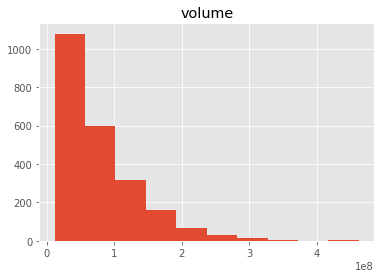

In [5]:
# Histogram distribution of the volume of quotation trade 
data.hist('volume')
plt.show()

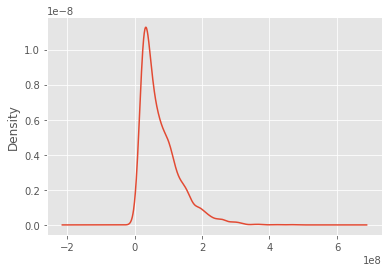

In [6]:
# Density probability of the distribution of the volume of quotation trade 
data['volume'].plot.kde()
plt.show()

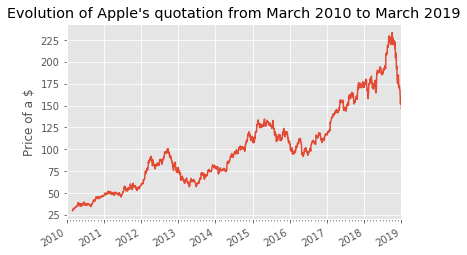

In [7]:
# Plot the evolution of Apple's quotation
import matplotlib.dates as mdates
import datetime

years = mdates.YearLocator()  
months = mdates.MonthLocator()  
yearsFmt = mdates.DateFormatter('%Y')

dates=np.array(data['date'].values.tolist())
dates=pd.to_datetime(dates, format='%Y/%m/%d')

fig, ax = plt.subplots()
ax.plot(dates, np.array(data['high'].values.tolist()))

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

# round to nearest years...
datemax = np.datetime64(dates[0], 'Y')
datemin = np.datetime64(dates[-1], 'Y') 
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y/%m/%d')
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

plt.title("Evolution of Apple's quotation from March 2010 to March 2019")
plt.ylabel("Price of a $")
plt.show()

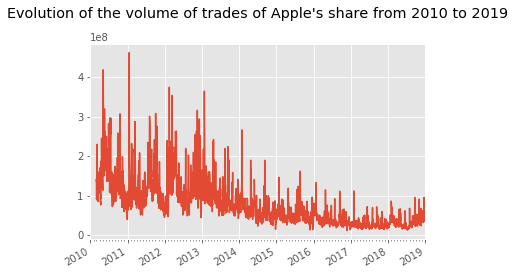

In [8]:
# Plot the evolution of the volume of trades of Apple's share 
import matplotlib.dates as mdates
import datetime

years = mdates.YearLocator()  
months = mdates.MonthLocator()  
yearsFmt = mdates.DateFormatter('%Y')

dates=np.array(data['date'].values.tolist())
dates=pd.to_datetime(dates, format='%Y/%m/%d')

fig, ax = plt.subplots()
ax.plot(dates, np.array(data['volume'].values.tolist()))

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

# round to nearest years...
datemax = np.datetime64(dates[0], 'Y')
datemin = np.datetime64(dates[-1], 'Y') 
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y/%m/%d')
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

plt.title("Evolution of the volume of trades of Apple's share from 2010 to 2019", y=1.1)
plt.show()

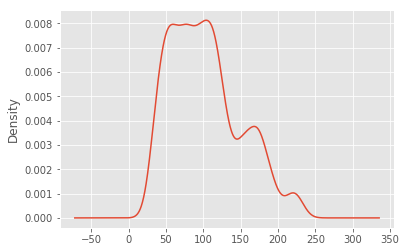

In [9]:
# Plot the probability distribution of the highest quotation of Apple reached each day
data['high'].plot.kde()
plt.show()

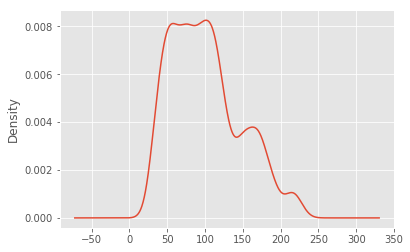

In [10]:
# Plot the probability distribution of the lowest quotation of Apple reached each day
data['low'].plot.kde()
plt.show()

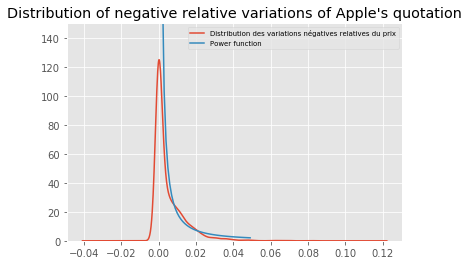

In [11]:
# Plot the distribution of negative relative variations of Apple's quotation
data['highpast'] = data.high.shift(1)
data['var'] = (data['high']-data['highpast'])/data['highpast']
data['varhigh'] = (abs(data['var'])-data['var'])/2 # negative part of the relative variation of price
data['varhigh'].plot.kde(label="Distribution des variations négatives relatives du prix")
X = np.arange(0.001,0.05,0.001)
Alpha = 1.4
c=1/33
def f(x): 
    return c/(x**Alpha)
plt.plot(X,f(X),label="Power function")
plt.ylim(0,150)
plt.legend(loc='upper right',fontsize='x-small')
plt.ylabel("")
plt.title("Distribution of negative relative variations of Apple's quotation")
plt.show()

This distribution looks to have a power-tail. Then we will assume that this law is in the domain of attraction of Frechet, of which the parameter will be estimated below.

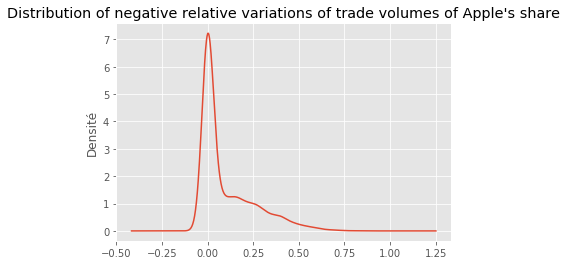

In [12]:
# Plot the distribution of negative relative variations of trades of Apple's share
data['volpast']=data.volume.shift(1)
data['varrelvol']=(data['volume']-data['volpast'])/data['volpast']
data['varrelnvol']=(abs(data['varrelvol'])-data['varrelvol'])/2 #negative part of the relative variation of price
data['varrelnvol'].plot.kde()
plt.ylabel("Densité")
plt.title("Distribution of negative relative variations of trade volumes of Apple's share")
plt.show()

As risk averse Apple stakeholders, we want to estimate the highest quantiles of the distribution of the negative part of the variation of sale prices.

# Hill Estimator

In [13]:
# Converting the data to numpy array
datasorted = data.sort_values(by = 'varhigh') # We look at the variation of the highest quotation reached each day
datasorted = datasorted.drop(datasorted[datasorted['varhigh']==0.0].index)
datasorted = datasorted.dropna()
n = datasorted.shape[0]
print(n) # Number of days where the variation of Apple's quotation is negative 
varhigh = np.array(datasorted['varhigh'].values.tolist())
varhigh # List of the sorted negative variations 

1183


array([4.84109936e-05, 6.92041522e-05, 8.58074481e-05, ...,
       6.81923405e-02, 6.97371446e-02, 8.14084274e-02])

In [14]:
# Formulas of the Hill Estimator
def alpha_hill(Threshold):
    return np.mean(np.log(varhigh[Threshold:n]/varhigh[Threshold]))

def quantile(a,Threshold):
    return varhigh[Threshold]*((n-Threshold)/(n*(1-a)))**(1/alpha_hill(Threshold))

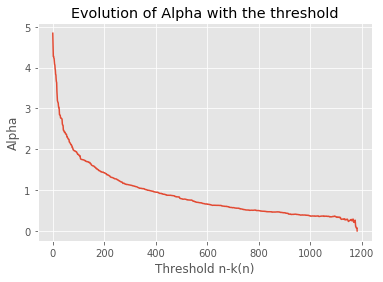

In [15]:
# Plot the evolution of Alpha with the threshold
plt.plot(np.arange(n),np.array([alpha_hill(x) for x in range(n)]))
plt.title("Evolution of Alpha with the threshold")
plt.ylabel("Alpha")
plt.xlabel("Threshold n-k(n)")
plt.show()

1.411878008544191


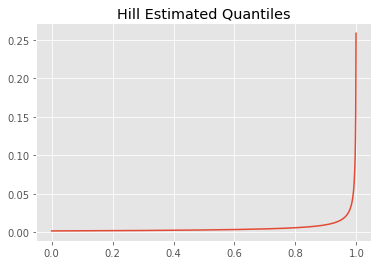

In [16]:
# We choose the Threshold "high but not too high", and so that Alpha does not change so much if we change the Threshold a little bit
# Second method to choose the Threshold : cf function best_threshold below
Threshold = 204
Alpha = alpha_hill(Threshold)
print(Alpha) # Given the threshold 204, alpha estimation of the Fréchet Law 
plt.plot(np.array([i*0.001 for i in range(1000)]),quantile(np.array([i*0.001 for i in range(1000)]),Threshold))
plt.title('Hill Estimated Quantiles')
plt.show()

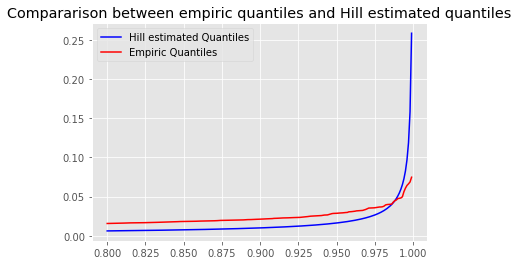

In [17]:
# Compararison between empiric quantiles and Hill estimated quantiles
import scipy.stats
qhill = np.array([quantile(i*0.001,Threshold) for i in range(800,1000)])
qemp = scipy.stats.mstats.mquantiles(varhigh,[0.001*i for i in range(800,1000)])
X = np.array([0.001*i for i in range(800,1000)])
plt.plot(X,qhill,color='b',label='Hill estimated Quantiles')
plt.plot(X,qemp,color='r',label='Empiric Quantiles')
plt.legend(loc='best')
plt.title('Compararison between empiric quantiles and Hill estimated quantiles')
plt.show()

In [18]:
# Choice of the Threshold minimizing the difference between Empiric Percentiles and Hill Percentiles estimates, for the last k perthousands
def best_threshold(k):
    bt = 0
    qemp = scipy.stats.mstats.mquantiles(varhigh,[0.001*i for i in range(1000-k,1000)])
    var = np.sum(abs(np.array([quantile(i*0.001,0) for i in range(1000-k,1000)])-qemp))
    for t in range(n):
        qhill = np.array([quantile(i*0.001,t) for i in range(1000-k,1000)])
        vartmp = np.sum(abs(qhill-qemp))
        if vartmp < var:
            var = vartmp
            bt = t
    return bt
best_threshold(100)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


204

In [19]:
# Print our Hill estimated quantiles
print(quantile(0.99,Threshold))
print(quantile(0.995,Threshold))
print(quantile(0.997,Threshold))
print(quantile(0.999,Threshold))

0.05059519136648967
0.08266500789398837
0.11870034062344785
0.25845547276742037


According to this model, less than 0.5% of the negative relative variations of the sale price in a day of Apple's actions are above 8% (given that there is approximatively 1 day out of 2 where the variation is negative). 

# Pick over Threshold

In [20]:
Threshold = 0.01 # Arbitrary choice
Exceedences = datasorted[datasorted['varhigh']>Threshold] # Only keep values above a threshold
Excarray = np.array(Exceedences['varhigh'].values.tolist())
f = Exceedences.shape[0]/datasorted.shape[0]
f # Percentage of variations that are above the threshold

0.38461538461538464

In [21]:
# We assume that the exceedences follow a generalized law of Pareto of which the parameter are estimated using maximum likelihood
# Negative Log Likelihood
def op_log_likelihood(Teta):
    Beta=Teta[0]
    Xi=Teta[1]
    S=0
    for i in range(len(Excarray)):
        S=S+np.log(1+Xi*(Excarray[i]+Threshold)/Beta)
    S=S*(1+1/Xi)
    S=S+n*np.log(Beta)
    return S

In [22]:
# Sanity check
op_log_likelihood(np.array([1,1]))

25.918861999561877

In [23]:
# Estimate theta with an approximated maximum likelihood which is equivalent to minimize negative log likelihood
import scipy.optimize
bnds = ((0.01, None), (0.01, None))
m = scipy.optimize.minimize(op_log_likelihood,np.array([10,10]),bounds=bnds)
m

      fun: -4249.689530415582
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.16263766e+04, -1.81898940e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 39
      nit: 5
   status: 0
  success: True
        x: array([0.01     , 0.5627627])

In [24]:
# Compare the 1/alpha obtained here 0.56 and the one that we had previously will Hill estimation
1/Alpha

0.708276489858437

In [25]:
# Get parameters of the Pareto Law
Beta = m.x[0]
Xi = m.x[1]

In [26]:
# Comparison between estimated survival function and empiric survival function
def f_survival_tshifted(y):
    return f*(1+Xi*y/Beta)**(-1/Xi)

def f_survival_empiric(y):
    return(datasorted[datasorted['varhigh']>Threshold+y].shape[0]/datasorted.shape[0])

for i in range(10):
    print(f_survival_tshifted(0.01*i))
    print(f_survival_empiric(0.01*i))

0.38461538461538464
0.38461538461538464
0.17397579384736248
0.11411665257819104
0.10072472703722996
0.042265426880811495
0.06635452031017927
0.014370245139475908
0.047335515883378275
0.006762468300929839
0.03564356997149604
0.00507185122569738
0.02791027137255037
0.0008453085376162299
0.022511959067898865
0.0008453085376162299
0.01858428692980623
0.0
0.01563127358856503
0.0


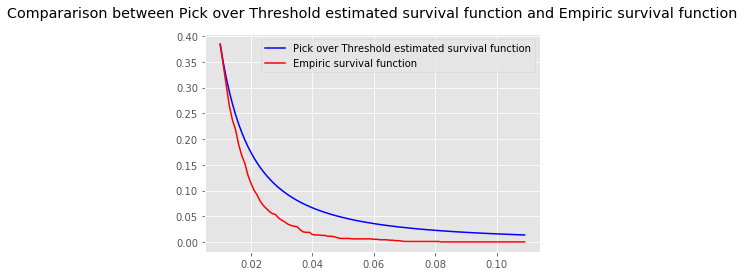

In [27]:
# Plot comparison between estimated survival function and empiric survival function
X = np.array([Threshold+0.001*i for i in range(100)])
plt.plot(X,np.array([f_survival_tshifted(0.001*i) for i in range(100)]),color='b',label='Pick over Threshold estimated survival function')
plt.plot(X,np.array([f_survival_empiric(0.001*i) for i in range(100)]),color='r',label='Empiric survival function')
plt.legend(loc='best')
plt.title('Compararison between Pick over Threshold estimated survival function and Empiric survival function', y=1.05)
plt.show()

Our estimated survival function seems consistently above the empiric survival function, which means that we are probably overestimating risks using it.

C:\Users\Antoine\AppData\Roaming\Python\Python36\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Antoine\AppData\Roaming\Python\Python36\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


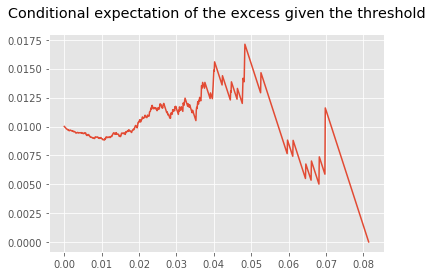

In [28]:
# We chose the threshold so that after it, the the conditional expectation of the excess given the threshold is almost linear
X = np.array([k*0.0001 for k in range(10000)])
plt.plot(X,np.array([np.mean(np.array(datasorted[datasorted['varhigh']>k*0.0001]['varhigh'].values.tolist())-k*0.0001) for k in range(10000)]))
plt.title("Conditional expectation of the excess given the threshold", y=1.05)
plt.show()

In [29]:
# It is not so much linear after 0.05 though ... How many values are concerned ?
datasorted[datasorted['varhigh']>0.05].shape[0]

8

In [30]:
# What is the estimated percentage of negative relative variations of Apple that exceed 4% ?
f_survival_tshifted(0.04)

0.047335515883378275

According to this model, 4.7% of the negative relative variations of the sale price in a day of Apple's actions are above 4% (given that there is approximatively 1 day out of 2 where the variation is negative).